In [1]:
import gc
import os
import sys
import warnings
from glob import glob

import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn as nn
import torch.nn.functional as F
from segmentation_models_pytorch.decoders.unet.decoder import DecoderBlock
from timm.models.resnet import resnet10t, resnet34d
from torch.cuda import amp
from tqdm import tqdm
from einops import rearrange


In [3]:
sys.path.append('/kaggle/working/notebook/experiment/stacked_unet')
from script.metrics import *
from script.dataset import *
from script.helper import *
from script.scheduler import *
from script.loss import *

### Config

In [4]:
class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'
    comp_dir_path = '/kaggle/input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'

    dataset_path = "/kaggle/working/dataset_train/"
    train_dataset_path = "/kaggle/working/dataset_train/nonflatten/25-37/"
    dataset_range = train_dataset_path.split("/")[-2]

    exp_name = os.getcwd().split('/')[-1]

    # ============== model cfg =============

    z_start = int(train_dataset_path.rstrip("/").split("/")[-1].split("-")[0])
    z_end = int(train_dataset_path.rstrip("/").split("/")[-1].split("-")[1])
    in_chans = z_end-z_start+1
    crop_depth = 6
    random_shift = random.randint(0, 0)
    layer_shift = [0,2,4,6]
    
    # ============== training cfg =============
    size = 256
    tile_size = 256
    stride = tile_size //2

    train_batch_size = 64  # 32
    valid_batch_size = train_batch_size

    epochs = 25  # 15

    lr = 1e-4
    loss = "bce_dice_loss"


    # ============== fixed =============
    num_workers = 4
    seed = 42

    # ============== augmentation =============
    train_aug_list = [
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(),
        A.ShiftScaleRotate(p=0.5),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3),
                        mask_fill_value=0, p=0.5),
        A.Normalize(
            mean=[0] * in_chans,
            std=[1] * in_chans,
            max_pixel_value=65535,
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean=[0] * in_chans,
            std=[1] * in_chans,
            max_pixel_value=65535,
        ),
        ToTensorV2(transpose_mask=True),
    ]


warnings.filterwarnings("ignore")
torch.backends.cudnn.benchmark = True  # type: ignore

set_seed(CFG.seed)
os.makedirs(f'./{CFG.exp_name}/', exist_ok=True)


### Load data

In [6]:
def preprocess(image, fragment_i, split_i):
    return image



len(train_images) = 11194
train_images[0].shape = (256, 256, 13)
train_labels[0].shape = (256, 256, 1)
train_masks[0].shape = (256, 256, 1)

len(valid_images) = 3087
valid_images[0].shape = (256, 256, 13)
valid_labels[0].shape = (256, 256, 1)



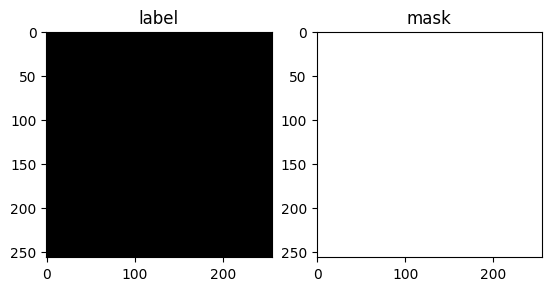

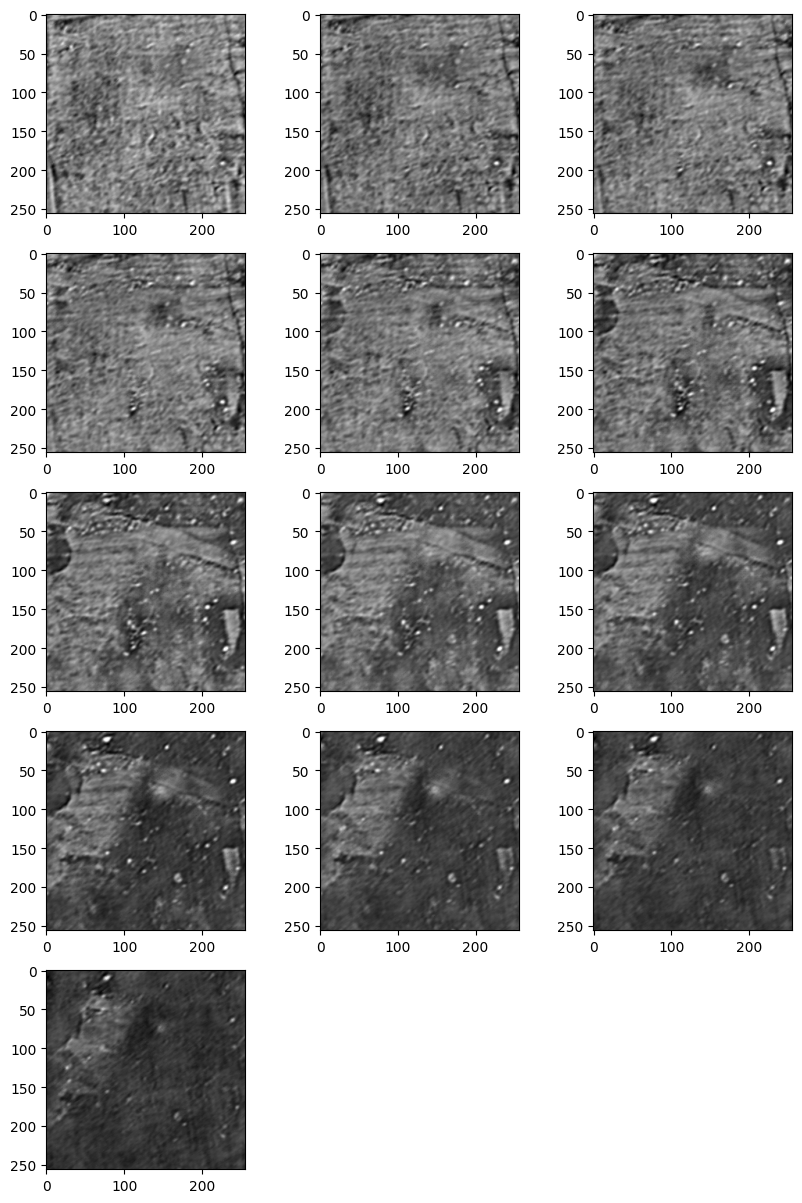

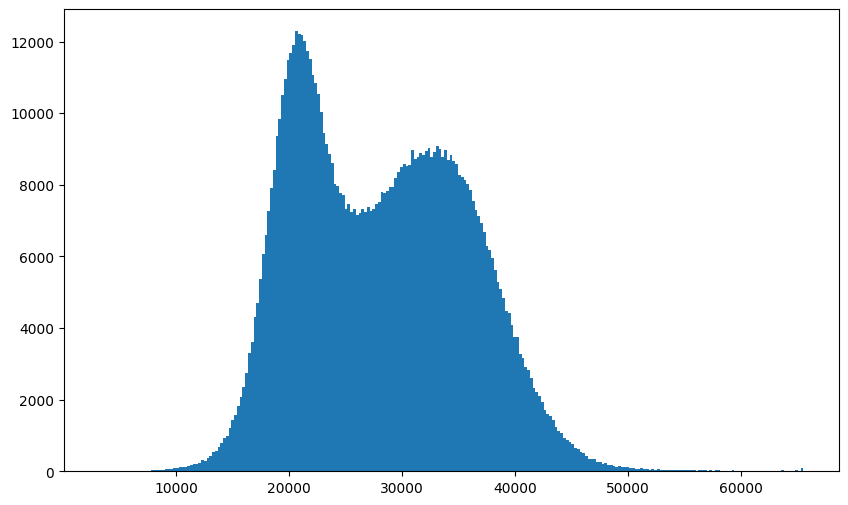

In [5]:
# confirmation

valid_fragment_i = 1
valid_split_i = 0

train_images, train_labels, train_masks, valid_images, valid_labels, valid_xyxys = get_train_valid_dataset(valid_fragment_i, valid_split_i, CFG, preprocess)

print(f"""
{len(train_images) = }
{train_images[0].shape = }
{train_labels[0].shape = }
{train_masks[0].shape = }

{len(valid_images) = }
{valid_images[0].shape = }
{valid_labels[0].shape = }
""")

id = random.randint(0, len(train_labels))
visualize_train_images(id, train_images, train_labels, train_masks)


### Model

In [5]:
class SmpUnetDecoder(nn.Module):
	def __init__(self,
	         in_channel,
	         skip_channel,
	         out_channel,
	    ):
		super().__init__()
		self.center = nn.Identity()

		i_channel = [in_channel,]+ out_channel[:-1]
		s_channel = skip_channel
		o_channel = out_channel
		block = [
			DecoderBlock(i, s, o, use_batchnorm=True, attention_type=None)
			for i, s, o in zip(i_channel, s_channel, o_channel)
		]
		self.block = nn.ModuleList(block)

	def forward(self, feature, skip):
		d = self.center(feature)
		decode = []
		for i, block in enumerate(self.block):
			s = skip[i]
			d = block(d, s)
			decode.append(d)

		last  = d
		return last, decode

class Net(nn.Module):
	def __init__(self,):
		super().__init__()
		self.output_type = ['inference', 'loss']

		conv_dim = 64
		encoder1_dim  = [conv_dim, 64, 128, 256, 512, ]
		decoder1_dim  = [256, 128, 64, 64,]

		self.encoder1 = resnet34d(pretrained=True, in_chans=CFG.crop_depth)

		self.decoder1 = SmpUnetDecoder(
			in_channel   = encoder1_dim[-1],
			skip_channel = encoder1_dim[:-1][::-1],
			out_channel  = decoder1_dim,
		)
		# -- pool attention weight
		self.weight1 = nn.ModuleList([
			nn.Sequential(
				nn.Conv2d(dim, dim, kernel_size=3, padding=1),
				nn.ReLU(inplace=True),
			) for dim in encoder1_dim
		])
		self.logit1 = nn.Conv2d(decoder1_dim[-1],1,kernel_size=1)

		#--------------------------------
		#
		encoder2_dim  = [64, 128, 256, 512]#
		decoder2_dim  = [128, 64, 32, ]
		self.encoder2 = resnet10t(pretrained=True, in_chans=decoder1_dim[-1])
		

		self.decoder2 = SmpUnetDecoder(
			in_channel   = encoder2_dim[-1],
			skip_channel = encoder2_dim[:-1][::-1],
			out_channel  = decoder2_dim,
		)
		self.logit2 = nn.Conv2d(decoder2_dim[-1],1,kernel_size=1)

	def forward(self, batch):
		v = batch
		B,C,H,W = v.shape
		random_shift = CFG.random_shift
		vv = [
            v[:, i+random_shift:i+random_shift+CFG.crop_depth] for i in CFG.layer_shift
		]
		K = len(vv)
		x = torch.cat(vv,0)
		#x = v

		#----------------------
		encoder = []
		e = self.encoder1
		x = e.conv1(x)
		x = e.bn1(x)
		x = e.act1(x);
		encoder.append(x)
		x = F.avg_pool2d(x, kernel_size=2, stride=2)
		x = e.layer1(x);
		encoder.append(x)
		x = e.layer2(x);
		encoder.append(x)
		x = e.layer3(x);
		encoder.append(x)
		x = e.layer4(x);
		encoder.append(x)
		# print('encoder', [f.shape for f in encoder])

		for i in range(len(encoder)):
			e = encoder[i]
			f = self.weight1[i](e)
			_, c, h, w = e.shape
			f = rearrange(f, '(K B) c h w -> B K c h w', K=K, B=B, h=h, w=w)  #
			e = rearrange(e, '(K B) c h w -> B K c h w', K=K, B=B, h=h, w=w)  #
			w = F.softmax(f, 1)
			e = (w * e).sum(1)
			encoder[i] = e

		feature = encoder[-1]
		skip = encoder[:-1][::-1]
		last, decoder = self.decoder1(feature, skip)
		logit1 = self.logit1(last)

		#----------------------
		x = last #.detach()
		#x = F.avg_pool2d(x,kernel_size=2,stride=2)
		encoder = []
		e = self.encoder2
		x = e.layer1(x); encoder.append(x)
		x = e.layer2(x); encoder.append(x)
		x = e.layer3(x); encoder.append(x)
		x = e.layer4(x); encoder.append(x)

		feature = encoder[-1]
		skip = encoder[:-1][::-1]
		last, decoder = self.decoder2(feature, skip)
		logit2 = self.logit2(last)
		logit2 = F.interpolate(logit2, size=(H
                                       , W), mode='bilinear', align_corners=False, antialias=True)

		return logit2


### Training

In [10]:
for fold_i, fold in enumerate(glob(f"{CFG.train_dataset_path}/*")):
    fold = os.path.basename(fold).split(".")[0]
    valid_fragment_i = int(fold.split("_")[0])
    valid_split_i = int(fold.split("_")[1])
    print(f"fold: {fold_i}")

    train_images, train_labels, train_masks, valid_images, valid_labels, valid_xyxys = get_train_valid_dataset(valid_fragment_i, valid_split_i, CFG, preprocess, "inklabels")

    dataloader_train, dataloader_valid = generate_dataloader(train_images, train_labels,  valid_images, valid_labels, valid_xyxys, CFG)

    n_train = len(dataloader_train)
    n_valid = len(dataloader_valid)

    gt_mask = generate_valid_label(valid_fragment_i, valid_split_i, CFG, "inklabels")
    gt_shape = gt_mask.shape


    num_gpus = torch.cuda.device_count()
    device_ids = list(range(num_gpus))

    model = Net()
    model = nn.DataParallel(model, device_ids=device_ids)
    model = model.cuda()

    scaler = amp.GradScaler()
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr)
    scheduler = get_scheduler(CFG, optimizer)

    fbeta = 0

    for epoch in range(CFG.epochs):
        model.train()
        cur_lr = f"LR : {scheduler.get_last_lr()[0]:.2E}"
        pbar_train = enumerate(dataloader_train)
        pbar_train = tqdm(pbar_train, total=n_train, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
        mloss_train, mloss_val, val_metric = 0.0, 0.0, 0.0

        for i, (fragments, masks) in pbar_train:
            fragments, masks = fragments.cuda(), masks.cuda()
            optimizer.zero_grad()
            with amp.autocast():  # type: ignore
                # logit1, pred_masks = model(fragments)
                # print(logit1.shape)
                # print(pred_masks.shape)
                # loss2 = criterion(pred_masks, masks)
                # loss1 = criterion(logit1, masks.resize_((masks.shape[0], 1,128 ,128)))
                # loss = loss1+loss2
                # scaler.scale(loss1).backward()
                # scaler.scale(loss2).backward()# type: ignore
                # scaler.step(optimizer)
                # scaler.update()
                pred_masks = model(fragments)
                loss = criterion(pred_masks, masks)
                scaler.scale(loss).backward()  # type: ignore
                scaler.step(optimizer)
                scaler.update()
                mloss_train += loss.detach().item()

            gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
            pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{CFG.epochs}", gpu_mem, cur_lr,
                                                                  f"Loss: {mloss_train / (i + 1):.4f}"))

        scheduler.step()
        model.eval()
        pbar_val = enumerate(dataloader_valid)
        pbar_val = tqdm(pbar_val, total=n_valid, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
        final_pred_mask = torch.zeros(gt_shape, dtype=torch.float32, device='cuda')  # type: ignore
        final_pred_count = torch.zeros(gt_shape)

        for i, (fragments, masks, xys) in pbar_val:
            fragments, masks = fragments.cuda(), masks.cuda()
            with torch.no_grad():
                pred_masks = model(fragments)
                mloss_val += criterion(pred_masks, masks).item()
                pred_masks = torch.sigmoid(pred_masks)

            for j, xy in enumerate(xys):
                final_pred_mask[xy[1]:xy[3], xy[0]:xy[2]] += pred_masks[j, 0]
                final_pred_count[xy[1]:xy[3], xy[0]:xy[2]] += np.ones((CFG.size, CFG.size))

            pbar_val.set_description(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))
        final_pred_mask = final_pred_mask.cpu()
        final_pred_mask /= final_pred_count

        fbeta_ = fbeta_score(final_pred_mask, gt_mask, 0.5)
        print(f"FBeta : {fbeta_:.4f}\tsave model:{fbeta_ > fbeta}")
        if fbeta_ > fbeta:
            fbeta = fbeta_
            model_path = f'./{CFG.exp_name}/{CFG.exp_name}_fold{fold_i}.pth'
            torch.save({'model': model.module.state_dict(),
                        'preds': final_pred_mask.numpy()},
                       model_path)
        print()

    del model, optimizer, scheduler, pbar_train, pbar_val, fragments, masks, train_images, train_labels, train_masks, valid_images, valid_labels, valid_xyxys
    gc.collect()
!curl -X POST -H 'Authorization: Bearer '$LINE -F 'message=セルの実行が終わりました！' https://notify-api.line.me/api/notify


fold: 1


Epoch 0/25  Mem : 22.2GB  LR : 1.00E-04  Loss: 0.5166: 100%|██████████| 177/177 [02:33<00:00,  1.15it/s]
Val Loss: 0.3676: 100%|██████████| 46/46 [00:13<00:00,  3.39it/s]


FBeta : 0.4333	save model:True


Epoch 1/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.3359: 100%|██████████| 177/177 [02:31<00:00,  1.17it/s]
Val Loss: 0.1805: 100%|██████████| 46/46 [00:13<00:00,  3.32it/s]


FBeta : 0.0090	save model:False


Epoch 2/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2660: 100%|██████████| 177/177 [02:32<00:00,  1.16it/s]
Val Loss: 0.1494: 100%|██████████| 46/46 [00:13<00:00,  3.33it/s]


FBeta : 0.4488	save model:True


Epoch 3/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2459: 100%|██████████| 177/177 [02:29<00:00,  1.18it/s]
Val Loss: 0.2454: 100%|██████████| 46/46 [00:13<00:00,  3.39it/s]


FBeta : 0.3078	save model:False


Epoch 4/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2319: 100%|██████████| 177/177 [02:29<00:00,  1.19it/s]
Val Loss: 0.1753: 100%|██████████| 46/46 [00:13<00:00,  3.48it/s]


FBeta : 0.1936	save model:False


Epoch 5/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2253: 100%|██████████| 177/177 [02:28<00:00,  1.19it/s]
Val Loss: 0.1555: 100%|██████████| 46/46 [00:13<00:00,  3.39it/s]


FBeta : 0.4756	save model:True


Epoch 6/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2129: 100%|██████████| 177/177 [02:29<00:00,  1.19it/s]
Val Loss: 0.1464: 100%|██████████| 46/46 [00:13<00:00,  3.42it/s]


FBeta : 0.5003	save model:True


Epoch 7/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2085: 100%|██████████| 177/177 [02:28<00:00,  1.19it/s]
Val Loss: 0.1659: 100%|██████████| 46/46 [00:13<00:00,  3.40it/s]


FBeta : 0.3193	save model:False


Epoch 8/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2023: 100%|██████████| 177/177 [02:29<00:00,  1.19it/s]
Val Loss: 0.1329: 100%|██████████| 46/46 [00:13<00:00,  3.42it/s]


FBeta : 0.5480	save model:True


Epoch 9/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1942: 100%|██████████| 177/177 [02:29<00:00,  1.19it/s]
Val Loss: 0.1254: 100%|██████████| 46/46 [00:13<00:00,  3.44it/s]


FBeta : 0.5901	save model:True


Epoch 10/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1882: 100%|██████████| 177/177 [02:29<00:00,  1.18it/s]
Val Loss: 0.1429: 100%|██████████| 46/46 [00:13<00:00,  3.43it/s]


FBeta : 0.4997	save model:False


Epoch 11/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1825: 100%|██████████| 177/177 [02:29<00:00,  1.19it/s]
Val Loss: 0.1366: 100%|██████████| 46/46 [00:13<00:00,  3.41it/s]


FBeta : 0.5537	save model:False


Epoch 12/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1752: 100%|██████████| 177/177 [02:28<00:00,  1.19it/s]
Val Loss: 0.1350: 100%|██████████| 46/46 [00:13<00:00,  3.48it/s]


FBeta : 0.5754	save model:False


Epoch 13/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1680: 100%|██████████| 177/177 [02:29<00:00,  1.19it/s]
Val Loss: 0.1447: 100%|██████████| 46/46 [00:13<00:00,  3.39it/s]


FBeta : 0.5086	save model:False


Epoch 14/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1653: 100%|██████████| 177/177 [02:28<00:00,  1.19it/s]
Val Loss: 0.1391: 100%|██████████| 46/46 [00:13<00:00,  3.49it/s]


FBeta : 0.5849	save model:False


Epoch 15/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1571: 100%|██████████| 177/177 [02:25<00:00,  1.22it/s]
Val Loss: 0.1352: 100%|██████████| 46/46 [00:13<00:00,  3.47it/s]


FBeta : 0.5771	save model:False


Epoch 16/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1525: 100%|██████████| 177/177 [02:25<00:00,  1.22it/s]
Val Loss: 0.1515: 100%|██████████| 46/46 [00:13<00:00,  3.51it/s]


FBeta : 0.5315	save model:False


Epoch 17/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1473: 100%|██████████| 177/177 [02:25<00:00,  1.22it/s]
Val Loss: 0.1431: 100%|██████████| 46/46 [00:13<00:00,  3.48it/s]


FBeta : 0.5942	save model:True


Epoch 18/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1410: 100%|██████████| 177/177 [02:25<00:00,  1.22it/s]
Val Loss: 0.1418: 100%|██████████| 46/46 [00:13<00:00,  3.47it/s]


FBeta : 0.5876	save model:False


Epoch 19/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1343: 100%|██████████| 177/177 [02:25<00:00,  1.22it/s]
Val Loss: 0.1385: 100%|██████████| 46/46 [00:13<00:00,  3.47it/s]


FBeta : 0.6078	save model:True


Epoch 20/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1328: 100%|██████████| 177/177 [02:25<00:00,  1.22it/s]
Val Loss: 0.1522: 100%|██████████| 46/46 [00:13<00:00,  3.49it/s]


FBeta : 0.6164	save model:True


Epoch 21/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1278: 100%|██████████| 177/177 [02:25<00:00,  1.22it/s]
Val Loss: 0.1456: 100%|██████████| 46/46 [00:13<00:00,  3.46it/s]


FBeta : 0.6067	save model:False


Epoch 22/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1245: 100%|██████████| 177/177 [02:27<00:00,  1.20it/s]
Val Loss: 0.1432: 100%|██████████| 46/46 [00:13<00:00,  3.42it/s]


FBeta : 0.6031	save model:False


Epoch 23/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1227: 100%|██████████| 177/177 [02:27<00:00,  1.20it/s]
Val Loss: 0.1514: 100%|██████████| 46/46 [00:13<00:00,  3.46it/s]


FBeta : 0.6126	save model:False


Epoch 24/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1204: 100%|██████████| 177/177 [02:27<00:00,  1.20it/s]
Val Loss: 0.1515: 100%|██████████| 46/46 [00:13<00:00,  3.38it/s]


FBeta : 0.6130	save model:False

fold: 2


Epoch 0/25  Mem : 22.2GB  LR : 1.00E-04  Loss: 0.4760: 100%|██████████| 177/177 [02:29<00:00,  1.18it/s]
Val Loss: 0.4613: 100%|██████████| 46/46 [00:13<00:00,  3.41it/s]


FBeta : 0.3282	save model:True


Epoch 1/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.3124: 100%|██████████| 177/177 [02:28<00:00,  1.19it/s]
Val Loss: 0.3824: 100%|██████████| 46/46 [00:13<00:00,  3.38it/s]


FBeta : 0.0000	save model:False


Epoch 2/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2354: 100%|██████████| 177/177 [02:27<00:00,  1.20it/s]
Val Loss: 0.3799: 100%|██████████| 46/46 [00:13<00:00,  3.44it/s]


FBeta : 0.0484	save model:False


Epoch 3/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2125: 100%|██████████| 177/177 [02:26<00:00,  1.21it/s]
Val Loss: 0.3479: 100%|██████████| 46/46 [00:13<00:00,  3.44it/s]


FBeta : 0.1895	save model:False


Epoch 4/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2000: 100%|██████████| 177/177 [02:26<00:00,  1.21it/s]
Val Loss: 0.3389: 100%|██████████| 46/46 [00:13<00:00,  3.44it/s]


FBeta : 0.1347	save model:False


Epoch 5/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1935: 100%|██████████| 177/177 [02:26<00:00,  1.21it/s]
Val Loss: 0.3153: 100%|██████████| 46/46 [00:13<00:00,  3.46it/s]


FBeta : 0.4634	save model:True


Epoch 6/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1867: 100%|██████████| 177/177 [02:26<00:00,  1.21it/s]
Val Loss: 0.3207: 100%|██████████| 46/46 [00:13<00:00,  3.44it/s]


FBeta : 0.3726	save model:False


Epoch 7/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1795: 100%|██████████| 177/177 [02:26<00:00,  1.21it/s]
Val Loss: 0.3532: 100%|██████████| 46/46 [00:13<00:00,  3.45it/s]


FBeta : 0.4144	save model:False


Epoch 8/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1749: 100%|██████████| 177/177 [02:27<00:00,  1.20it/s]
Val Loss: 0.3243: 100%|██████████| 46/46 [00:13<00:00,  3.41it/s]


FBeta : 0.5253	save model:True


Epoch 9/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1697: 100%|██████████| 177/177 [02:28<00:00,  1.19it/s]
Val Loss: 0.3298: 100%|██████████| 46/46 [00:13<00:00,  3.40it/s]


FBeta : 0.5500	save model:True


Epoch 10/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1645: 100%|██████████| 177/177 [02:28<00:00,  1.19it/s]
Val Loss: 0.3444: 100%|██████████| 46/46 [00:13<00:00,  3.42it/s]


FBeta : 0.5104	save model:False


Epoch 11/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1599: 100%|██████████| 177/177 [02:28<00:00,  1.19it/s]
Val Loss: 0.3775: 100%|██████████| 46/46 [00:13<00:00,  3.41it/s]


FBeta : 0.3272	save model:False


Epoch 12/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1562: 100%|██████████| 177/177 [02:28<00:00,  1.19it/s]
Val Loss: 0.2874: 100%|██████████| 46/46 [00:13<00:00,  3.45it/s]


FBeta : 0.6056	save model:True


Epoch 13/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1527: 100%|██████████| 177/177 [02:28<00:00,  1.19it/s]
Val Loss: 0.3177: 100%|██████████| 46/46 [00:13<00:00,  3.41it/s]


FBeta : 0.5458	save model:False


Epoch 14/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1471: 100%|██████████| 177/177 [02:28<00:00,  1.19it/s]
Val Loss: 0.3195: 100%|██████████| 46/46 [00:13<00:00,  3.41it/s]


FBeta : 0.5429	save model:False


Epoch 15/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1401: 100%|██████████| 177/177 [02:25<00:00,  1.22it/s]
Val Loss: 0.3146: 100%|██████████| 46/46 [00:13<00:00,  3.49it/s]


FBeta : 0.5925	save model:False


Epoch 16/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1379: 100%|██████████| 177/177 [02:25<00:00,  1.22it/s]
Val Loss: 0.3131: 100%|██████████| 46/46 [00:13<00:00,  3.49it/s]


FBeta : 0.5742	save model:False


Epoch 17/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1326: 100%|██████████| 177/177 [02:25<00:00,  1.22it/s]
Val Loss: 0.2937: 100%|██████████| 46/46 [00:13<00:00,  3.49it/s]


FBeta : 0.6132	save model:True


Epoch 18/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1299: 100%|██████████| 177/177 [02:25<00:00,  1.22it/s]
Val Loss: 0.3121: 100%|██████████| 46/46 [00:13<00:00,  3.47it/s]


FBeta : 0.5784	save model:False


Epoch 19/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1236: 100%|██████████| 177/177 [02:25<00:00,  1.22it/s]
Val Loss: 0.3349: 100%|██████████| 46/46 [00:13<00:00,  3.46it/s]


FBeta : 0.6141	save model:True


Epoch 20/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1221: 100%|██████████| 177/177 [02:27<00:00,  1.20it/s]
Val Loss: 0.3282: 100%|██████████| 46/46 [00:13<00:00,  3.38it/s]


FBeta : 0.6087	save model:False


Epoch 21/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1170: 100%|██████████| 177/177 [02:28<00:00,  1.19it/s]
Val Loss: 0.3608: 100%|██████████| 46/46 [00:13<00:00,  3.39it/s]


FBeta : 0.6028	save model:False


Epoch 22/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1147: 100%|██████████| 177/177 [02:28<00:00,  1.19it/s]
Val Loss: 0.3285: 100%|██████████| 46/46 [00:13<00:00,  3.41it/s]


FBeta : 0.6310	save model:True


Epoch 23/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1128: 100%|██████████| 177/177 [02:28<00:00,  1.19it/s]
Val Loss: 0.3637: 100%|██████████| 46/46 [00:13<00:00,  3.39it/s]


FBeta : 0.6058	save model:False


Epoch 24/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1104: 100%|██████████| 177/177 [02:28<00:00,  1.19it/s]
Val Loss: 0.3503: 100%|██████████| 46/46 [00:13<00:00,  3.40it/s]


FBeta : 0.6213	save model:False

fold: 3


Epoch 0/25  Mem : 22.2GB  LR : 1.00E-04  Loss: 0.6377: 100%|██████████| 177/177 [02:28<00:00,  1.19it/s]
Val Loss: 0.5705: 100%|██████████| 46/46 [00:13<00:00,  3.38it/s]


FBeta : 0.0000	save model:False


Epoch 1/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.4035: 100%|██████████| 177/177 [02:28<00:00,  1.19it/s]
Val Loss: 0.3821: 100%|██████████| 46/46 [00:13<00:00,  3.43it/s]


FBeta : 0.0000	save model:False


Epoch 2/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2666: 100%|██████████| 177/177 [02:26<00:00,  1.21it/s]
Val Loss: 0.3540: 100%|██████████| 46/46 [00:13<00:00,  3.50it/s]


FBeta : 0.2310	save model:True


Epoch 3/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2337: 100%|██████████| 177/177 [02:25<00:00,  1.22it/s]
Val Loss: 0.3384: 100%|██████████| 46/46 [00:13<00:00,  3.49it/s]


FBeta : 0.1238	save model:False


Epoch 4/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2181: 100%|██████████| 177/177 [02:25<00:00,  1.22it/s]
Val Loss: 0.3874: 100%|██████████| 46/46 [00:13<00:00,  3.48it/s]


FBeta : 0.0088	save model:False


Epoch 5/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2094: 100%|██████████| 177/177 [02:25<00:00,  1.22it/s]
Val Loss: 0.3055: 100%|██████████| 46/46 [00:13<00:00,  3.47it/s]


FBeta : 0.4446	save model:True


Epoch 6/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2019: 100%|██████████| 177/177 [02:25<00:00,  1.22it/s]
Val Loss: 0.3121: 100%|██████████| 46/46 [00:13<00:00,  3.49it/s]


FBeta : 0.4694	save model:True


Epoch 7/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1943: 100%|██████████| 177/177 [02:25<00:00,  1.22it/s]
Val Loss: 0.2985: 100%|██████████| 46/46 [00:13<00:00,  3.47it/s]


FBeta : 0.5601	save model:True


Epoch 8/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1879: 100%|██████████| 177/177 [02:25<00:00,  1.22it/s]
Val Loss: 0.2998: 100%|██████████| 46/46 [00:13<00:00,  3.48it/s]


FBeta : 0.5283	save model:False


Epoch 9/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1857: 100%|██████████| 177/177 [02:25<00:00,  1.22it/s]
Val Loss: 0.2913: 100%|██████████| 46/46 [00:13<00:00,  3.48it/s]


FBeta : 0.5219	save model:False


Epoch 10/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1816: 100%|██████████| 177/177 [02:25<00:00,  1.22it/s]
Val Loss: 0.3445: 100%|██████████| 46/46 [00:13<00:00,  3.48it/s]


FBeta : 0.4883	save model:False


Epoch 11/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1752: 100%|██████████| 177/177 [02:25<00:00,  1.22it/s]
Val Loss: 0.3513: 100%|██████████| 46/46 [00:13<00:00,  3.51it/s]


FBeta : 0.3933	save model:False


Epoch 12/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1689: 100%|██████████| 177/177 [02:27<00:00,  1.20it/s]
Val Loss: 0.2676: 100%|██████████| 46/46 [00:13<00:00,  3.43it/s]


FBeta : 0.6327	save model:True


Epoch 13/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1665: 100%|██████████| 177/177 [02:28<00:00,  1.19it/s]
Val Loss: 0.3074: 100%|██████████| 46/46 [00:13<00:00,  3.41it/s]


FBeta : 0.4363	save model:False


Epoch 14/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1610: 100%|██████████| 177/177 [02:28<00:00,  1.19it/s]
Val Loss: 0.2691: 100%|██████████| 46/46 [00:13<00:00,  3.42it/s]


FBeta : 0.6360	save model:True


Epoch 15/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1557: 100%|██████████| 177/177 [02:28<00:00,  1.19it/s]
Val Loss: 0.2887: 100%|██████████| 46/46 [00:13<00:00,  3.43it/s]


FBeta : 0.5862	save model:False


Epoch 16/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1520: 100%|██████████| 177/177 [02:27<00:00,  1.20it/s]
Val Loss: 0.2703: 100%|██████████| 46/46 [00:13<00:00,  3.43it/s]


FBeta : 0.6550	save model:True


Epoch 17/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1465: 100%|██████████| 177/177 [02:27<00:00,  1.20it/s]
Val Loss: 0.2748: 100%|██████████| 46/46 [00:13<00:00,  3.44it/s]


FBeta : 0.6435	save model:False


Epoch 18/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1427: 100%|██████████| 177/177 [02:28<00:00,  1.20it/s]
Val Loss: 0.2955: 100%|██████████| 46/46 [00:13<00:00,  3.45it/s]


FBeta : 0.6236	save model:False


Epoch 19/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1374: 100%|██████████| 177/177 [02:28<00:00,  1.20it/s]
Val Loss: 0.2842: 100%|██████████| 46/46 [00:13<00:00,  3.44it/s]


FBeta : 0.6359	save model:False


Epoch 20/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1340: 100%|██████████| 177/177 [02:27<00:00,  1.20it/s]
Val Loss: 0.2695: 100%|██████████| 46/46 [00:13<00:00,  3.45it/s]


FBeta : 0.6352	save model:False


Epoch 21/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1292: 100%|██████████| 177/177 [02:27<00:00,  1.20it/s]
Val Loss: 0.2831: 100%|██████████| 46/46 [00:13<00:00,  3.44it/s]


FBeta : 0.5990	save model:False


Epoch 22/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1262: 100%|██████████| 177/177 [02:27<00:00,  1.20it/s]
Val Loss: 0.2735: 100%|██████████| 46/46 [00:13<00:00,  3.46it/s]


FBeta : 0.6172	save model:False


Epoch 23/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1246: 100%|██████████| 177/177 [02:27<00:00,  1.20it/s]
Val Loss: 0.2840: 100%|██████████| 46/46 [00:13<00:00,  3.43it/s]


FBeta : 0.6456	save model:False


Epoch 24/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1208: 100%|██████████| 177/177 [02:27<00:00,  1.20it/s]
Val Loss: 0.2826: 100%|██████████| 46/46 [00:13<00:00,  3.43it/s]


FBeta : 0.6419	save model:False

fold: 4


Epoch 0/25  Mem : 22.2GB  LR : 1.00E-04  Loss: 0.5620: 100%|██████████| 185/185 [02:34<00:00,  1.20it/s]
Val Loss: 0.4990: 100%|██████████| 38/38 [00:11<00:00,  3.40it/s]


FBeta : 0.0000	save model:True


Epoch 1/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.3632: 100%|██████████| 185/185 [02:34<00:00,  1.20it/s]
Val Loss: 0.2385: 100%|██████████| 38/38 [00:11<00:00,  3.39it/s]


FBeta : 0.0000	save model:False


Epoch 2/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2707: 100%|██████████| 185/185 [02:35<00:00,  1.19it/s]
Val Loss: 0.2949: 100%|██████████| 38/38 [00:11<00:00,  3.38it/s]


FBeta : 0.3589	save model:True


Epoch 3/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2459: 100%|██████████| 185/185 [02:35<00:00,  1.19it/s]
Val Loss: 0.2360: 100%|██████████| 38/38 [00:11<00:00,  3.40it/s]


FBeta : 0.4801	save model:True


Epoch 4/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2315: 100%|██████████| 185/185 [02:35<00:00,  1.19it/s]
Val Loss: 0.1961: 100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


FBeta : 0.4728	save model:False


Epoch 5/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2223: 100%|██████████| 185/185 [02:34<00:00,  1.19it/s]
Val Loss: 0.1946: 100%|██████████| 38/38 [00:11<00:00,  3.44it/s]


FBeta : 0.5350	save model:True


Epoch 6/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2129: 100%|██████████| 185/185 [02:32<00:00,  1.22it/s]
Val Loss: 0.1803: 100%|██████████| 38/38 [00:11<00:00,  3.43it/s]


FBeta : 0.5334	save model:False


Epoch 7/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2099: 100%|██████████| 185/185 [02:31<00:00,  1.22it/s]
Val Loss: 0.1896: 100%|██████████| 38/38 [00:10<00:00,  3.46it/s]


FBeta : 0.5415	save model:True


Epoch 8/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2029: 100%|██████████| 185/185 [02:32<00:00,  1.22it/s]
Val Loss: 0.2138: 100%|██████████| 38/38 [00:11<00:00,  3.44it/s]


FBeta : 0.2995	save model:False


Epoch 9/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1962: 100%|██████████| 185/185 [02:31<00:00,  1.22it/s]
Val Loss: 0.2621: 100%|██████████| 38/38 [00:11<00:00,  3.45it/s]


FBeta : 0.4179	save model:False


Epoch 10/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1889: 100%|██████████| 185/185 [02:31<00:00,  1.22it/s]
Val Loss: 0.1788: 100%|██████████| 38/38 [00:11<00:00,  3.45it/s]


FBeta : 0.6054	save model:True


Epoch 11/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1859: 100%|██████████| 185/185 [02:32<00:00,  1.22it/s]
Val Loss: 0.1787: 100%|██████████| 38/38 [00:11<00:00,  3.43it/s]


FBeta : 0.6079	save model:True


Epoch 12/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1788: 100%|██████████| 185/185 [02:33<00:00,  1.21it/s]
Val Loss: 0.1747: 100%|██████████| 38/38 [00:11<00:00,  3.39it/s]


FBeta : 0.5939	save model:False


Epoch 13/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1760: 100%|██████████| 185/185 [02:35<00:00,  1.19it/s]
Val Loss: 0.1839: 100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


FBeta : 0.5377	save model:False


Epoch 14/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1694: 100%|██████████| 185/185 [02:35<00:00,  1.19it/s]
Val Loss: 0.2027: 100%|██████████| 38/38 [00:11<00:00,  3.40it/s]


FBeta : 0.5005	save model:False


Epoch 15/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1655: 100%|██████████| 185/185 [02:35<00:00,  1.19it/s]
Val Loss: 0.1932: 100%|██████████| 38/38 [00:11<00:00,  3.37it/s]


FBeta : 0.5583	save model:False


Epoch 16/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1585: 100%|██████████| 185/185 [02:35<00:00,  1.19it/s]
Val Loss: 0.1755: 100%|██████████| 38/38 [00:11<00:00,  3.44it/s]


FBeta : 0.5933	save model:False


Epoch 17/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1535: 100%|██████████| 185/185 [02:31<00:00,  1.22it/s]
Val Loss: 0.1745: 100%|██████████| 38/38 [00:11<00:00,  3.43it/s]


FBeta : 0.6021	save model:False


Epoch 18/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1487: 100%|██████████| 185/185 [02:32<00:00,  1.22it/s]
Val Loss: 0.1755: 100%|██████████| 38/38 [00:11<00:00,  3.43it/s]


FBeta : 0.6240	save model:True


Epoch 19/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1449: 100%|██████████| 185/185 [02:32<00:00,  1.22it/s]
Val Loss: 0.1721: 100%|██████████| 38/38 [00:11<00:00,  3.44it/s]


FBeta : 0.6216	save model:False


Epoch 20/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1402: 100%|██████████| 185/185 [02:32<00:00,  1.22it/s]
Val Loss: 0.1805: 100%|██████████| 38/38 [00:11<00:00,  3.44it/s]


FBeta : 0.6298	save model:True


Epoch 21/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1361: 100%|██████████| 185/185 [02:32<00:00,  1.22it/s]
Val Loss: 0.1791: 100%|██████████| 38/38 [00:10<00:00,  3.47it/s]


FBeta : 0.5938	save model:False


Epoch 22/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1309: 100%|██████████| 185/185 [02:31<00:00,  1.22it/s]
Val Loss: 0.1792: 100%|██████████| 38/38 [00:10<00:00,  3.46it/s]


FBeta : 0.6012	save model:False


Epoch 23/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1303: 100%|██████████| 185/185 [02:32<00:00,  1.22it/s]
Val Loss: 0.1786: 100%|██████████| 38/38 [00:10<00:00,  3.46it/s]


FBeta : 0.6006	save model:False


Epoch 24/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.1254: 100%|██████████| 185/185 [02:31<00:00,  1.22it/s]
Val Loss: 0.1815: 100%|██████████| 38/38 [00:10<00:00,  3.46it/s]


FBeta : 0.5882	save model:False

curl: option -: is unknown
curl: try 'curl --help' or 'curl --manual' for more information


In [5]:
gt_area_list, dice_list, valid_label_gt_list, label_pred_list = inference_evaluation(CFG)

fbeta: 0.6281
fbeta: 0.6164
fbeta: 0.6310
fbeta: 0.6550
fbeta: 0.6298


In [6]:
print(f"{dice_evaluation(gt_area_list, dice_list):.4f}")


0.6321


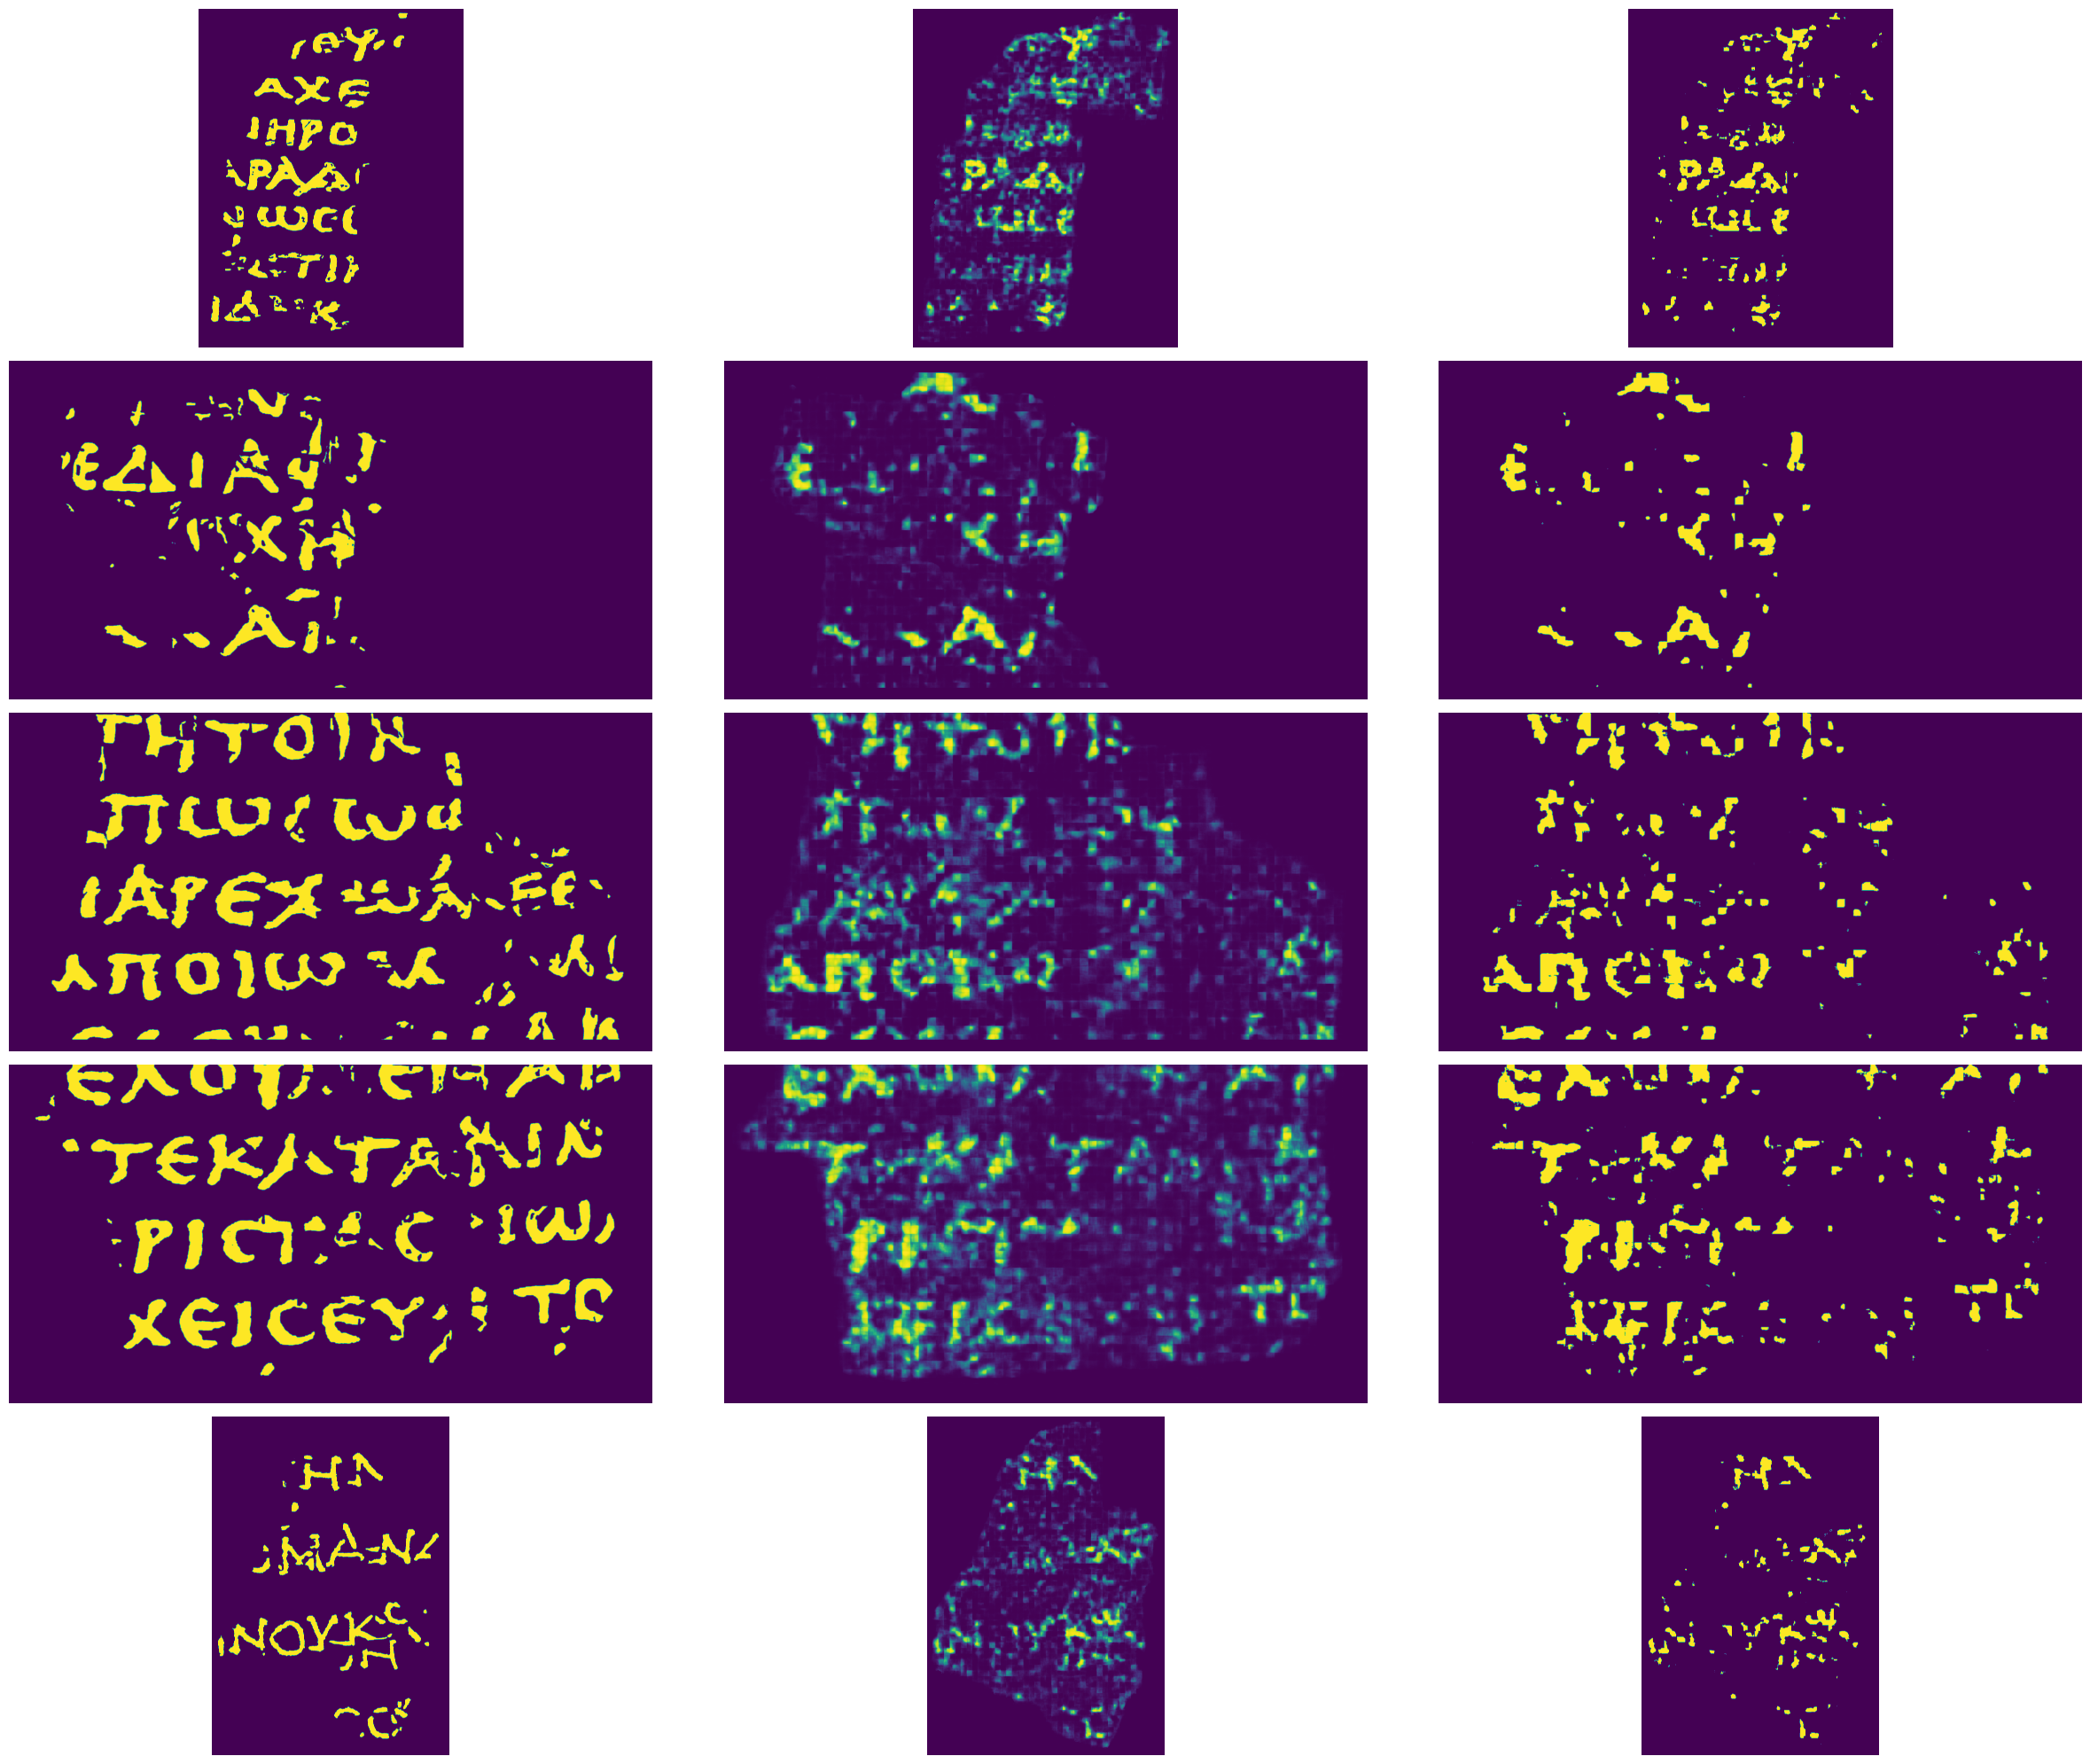

In [7]:
plot_inference(valid_label_gt_list, label_pred_list, CFG)